In [3]:
import h5py

with h5py.File("outputs/NCSX_output.h5", "r") as f:
    print(list(f["/"].keys()))  # top-level keys
    print("_equilibria" in f)  # True일 것

    # 내부 항목 보기
    print(list(f["_equilibria/0"].keys()))  # 여기에도 |B| 관련 없음


['__class__', '__version__', '_equilibria']
True
['_L', '_L_basis', '_L_grid', '_L_lmn', '_M', '_M_grid', '_N', '_NFP', '_N_grid', '_Psi', '_R_basis', '_R_lmn', '_R_sym', '_Z_basis', '_Z_lmn', '_Z_sym', '__class__', '__version__', '_anisotropy', '_atomic_number', '_axis', '_bdry_mode', '_current', '_electron_density', '_electron_temperature', '_ion_temperature', '_iota', '_pressure', '_spectral_indexing', '_surface', '_sym']


In [1]:
import h5py
import numpy as np

# DESC h5 파일 열기
filename = "outputs/NCSX_output.h5"
with h5py.File(filename, "r") as f:
    eq_path = "_equilibria/0"

    R_lmn = f[f"{eq_path}/_R_lmn"][:]
    R_modes = f[f"{eq_path}/_R_basis/_modes"][:]

    Z_lmn = f[f"{eq_path}/_Z_lmn"][:]
    Z_modes = f[f"{eq_path}/_Z_basis/_modes"][:]

    L_lmn = f[f"{eq_path}/_L_lmn"][:]
    L_modes = f[f"{eq_path}/_L_basis/_modes"][:]

# 격자 설정
Ns, Nθ, Nζ = 32, 64, 16
s = np.linspace(0, 1, Ns)
θ = np.linspace(0, 2 * np.pi, Nθ)
ζ = np.linspace(0, 2 * np.pi, Nζ)

S, T, Zz = np.meshgrid(s, θ, ζ, indexing="ij")

def fourier_sum(coeffs, modes, S, T, Zz):
    result = np.zeros_like(S)
    for i in range(len(coeffs)):
        l, m, n = modes[i]
        result += coeffs[i] * S**l * np.cos(m * T - n * Zz)
    return result

# R(s,θ,ζ), Z(s,θ,ζ), λ(s,θ,ζ) 복원
R = fourier_sum(R_lmn, R_modes, S, T, Zz)
Z = fourier_sum(Z_lmn, Z_modes, S, T, Zz)
lam = fourier_sum(L_lmn, L_modes, S, T, Zz)


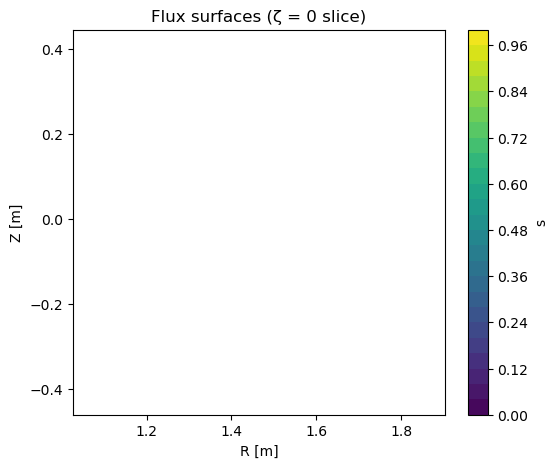

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.contourf(R[:, :, 0], Z[:, :, 0], S[:, :, 0], levels=30)
plt.xlabel("R [m]")
plt.ylabel("Z [m]")
plt.title("Flux surfaces (ζ = 0 slice)")
plt.axis("equal")
plt.colorbar(label="s")
plt.show()


In [4]:
def check_mode_structure(coeffs, modes, name="R"):
    print(f"\n--- Checking {name} ---")
    print("coeff shape:", coeffs.shape)
    print("modes shape:", modes.shape)
    print("first 5 modes and coeffs:")
    for i in range(min(5, len(coeffs))):
        print(f"  l={modes[i,0]}, m={modes[i,1]}, n={modes[i,2]}, coeff={coeffs[i]}")


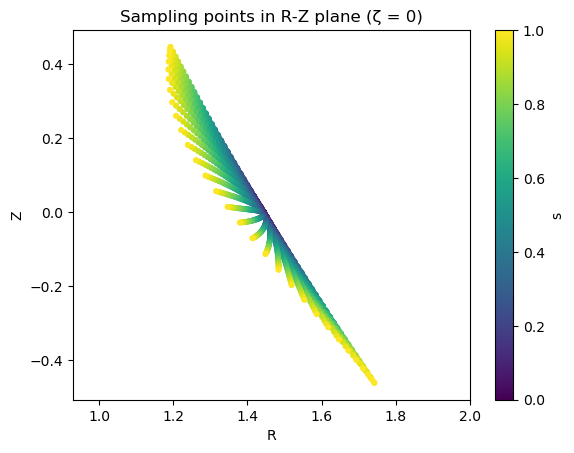

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(R[:, :, 0], Z[:, :, 0], c=S[:, :, 0], s=10)
plt.xlabel("R")
plt.ylabel("Z")
plt.title("Sampling points in R-Z plane (ζ = 0)")
plt.axis("equal")
plt.colorbar(label="s")
plt.show()

In [8]:
def partial_derivative(f, axis, grid_spacing):
    return np.gradient(f, grid_spacing, axis=axis, edge_order=2)

# 격자 간격 계산
ds = s[1] - s[0]
dt = θ[1] - θ[0]
dz = ζ[1] - ζ[0]

# ∂R/∂s, ∂R/∂θ, ∂R/∂ζ
dR_ds = partial_derivative(R, axis=0, grid_spacing=ds)
dR_dt = partial_derivative(R, axis=1, grid_spacing=dt)
dR_dz = partial_derivative(R, axis=2, grid_spacing=dz)

# ∂Z/∂s, ∂Z/∂θ, ∂Z/∂ζ
dZ_ds = partial_derivative(Z, axis=0, grid_spacing=ds)
dZ_dt = partial_derivative(Z, axis=1, grid_spacing=dt)
dZ_dz = partial_derivative(Z, axis=2, grid_spacing=dz)

# ∂λ/∂s, ∂λ/∂θ, ∂λ/∂ζ
dL_ds = partial_derivative(lam, axis=0, grid_spacing=ds)
dL_dt = partial_derivative(lam, axis=1, grid_spacing=dt)
dL_dz = partial_derivative(lam, axis=2, grid_spacing=dz)


In [9]:
# ∂r/∂s = (∂R/∂s, ∂Z/∂s, ∂λ/∂s)
e_s = np.stack([dR_ds, dZ_ds, dL_ds], axis=-1)
e_t = np.stack([dR_dt, dZ_dt, dL_dt], axis=-1)
e_z = np.stack([dR_dz, dZ_dz, dL_dz], axis=-1)

# Jacobian J = (e_s · (e_theta × e_zeta))
cross_tz = np.cross(e_t, e_z)
J = np.einsum('ijkl,ijkl->ijk', e_s, cross_tz)  # dot product

# DESC는 Ψ(s)만 저장하므로 ∂Ψ/∂s 필요
with h5py.File(filename, "r") as f:
    Psi_s = f["_equilibria/0/_Psi"][:]
dPsi_ds = np.gradient(Psi_s, ds)

# iota(s)도 불러옴
iota_s = f["_equilibria/0/_iota"][:]

# s index를 3D 격자에 맞춰 broadcast
dPsi = dPsi_ds[:, None, None]
iota = iota_s[:, None, None]

# B field 벡터 계산 (contravariant form)
B_vec = (dPsi / J[..., None]) * (
    np.cross(e_t, e_z) + iota * np.cross(e_z, e_s)
)  # shape (Ns, Nθ, Nζ, 3)


ValueError: Illegal slicing argument for scalar dataspace

In [10]:
with h5py.File(filename, "r") as f:
    print("Psi shape:", f["_equilibria/0/_Psi"].shape)

Psi shape: ()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# ========== 전 단계에서 이미 구한 값들 ==========
# R, Z, lam: (Ns, Nθ, Nζ) 위치 배열
# dR_ds, dR_dt, dR_dz, ...: 편미분
# s, θ, ζ: 1D 격자
# ds: s 간격
# filename: DESC .h5 파일 경로

# 벡터 구성
e_s = np.stack([dR_ds, dZ_ds, dL_ds], axis=-1)
e_t = np.stack([dR_dt, dZ_dt, dL_dt], axis=-1)
e_z = np.stack([dR_dz, dZ_dz, dL_dz], axis=-1)

# Jacobian 계산
cross_tz = np.cross(e_t, e_z)
J = np.einsum('ijkl,ijkl->ijk', e_s, cross_tz)

# Ψ(s) 없으므로 테스트용 선형 설정
Psi_s = np.linspace(0, 1, len(s))
dPsi_ds = np.gradient(Psi_s, ds)
dPsi = dPsi_ds[:, None, None]  # broadcast

# iota(s) 불러오기
with h5py.File(filename, "r") as f:
    iota_s = f["_equilibria/0/_iota"][()]
iota = iota_s[:, None, None]

# 자기장 벡터 계산
B_vec = (dPsi / J[..., None]) * (
    np.cross(e_t, e_z) + iota * np.cross(e_z, e_s)
)  # shape (Ns, Nθ, Nζ, 3)

# 자기장 크기 계산
B_mag = np.linalg.norm(B_vec, axis=-1)  # shape (Ns, Nθ, Nζ)

# ========== 시각화 ==========
ζ_index = 0  # ζ = 0 단면
R_slice = R[:, :, ζ_index]
Z_slice = Z[:, :, ζ_index]
B_slice = B_mag[:, :, ζ_index]

plt.figure(figsize=(6, 5))
plt.tricontourf(R_slice, Z_slice, B_slice, levels=50, cmap="plasma")
plt.xlabel("R [m]")
plt.ylabel("Z [m]")
plt.title("|B|(ζ = 0) from reconstructed geometry")
plt.axis("equal")
plt.colorbar(label="|B| [a.u.]")
plt.show()


TypeError: byte indices must be integers or slices, not tuple